In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
## load in the dataset
col1_names=['id', 'tweet_id', 'text', 'username']
col2_names = ['tweet_id', 'disease', 'label']
df1 = pd.read_csv("tweets/phm2017_tweets.csv", names=col1_names, header=None)
df2 = pd.read_csv("new_data/PHM2017.csv", names=col2_names, header=None)
df = pd.merge(df1, df2, on="tweet_id")
df = df.drop(['id', 'tweet_id', 'username', 'disease'], axis=1)
df['label'] = df['label'].astype(int)
print(df.dtypes)

text     object
label     int64
dtype: object


In [4]:
df.head()

,text,label
0,New Alzheimer Society resources to support a m...,1
1,What to Know About Thyroid and Alzheimer's htt...,1
2,Hippocampus ! If this part are damage we could...,1
3,How tackling hearing loss could reduce your ri...,1
4,Finding the fun in the fog of Alzheimer’s\nvia...,1


In [5]:
shape = df.shape
shape

(4416, 2)

In [6]:
# split into train test split
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [7]:
train_text.shape

(3091,)

In [8]:
temp_text.shape

(1325,)

In [9]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([3091, 280])


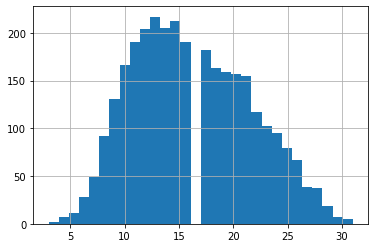

In [10]:
############### TOKENIZATION ###############
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

max_seq_len = 280 ## change this maybe?

def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)


train_indices = tokenize_and_pad_text(train_text, max_seq_len)
val_indices = tokenize_and_pad_text(val_text, max_seq_len)
test_indices = tokenize_and_pad_text(test_text, max_seq_len)

print(train_indices.shape)

In [11]:
train_indices[0]

tensor([  101,  1018,  3928,  5878,  2055, 20310,  1005,  1055,  1998,  3652,
         3080,  1064,  5863,  5253,  1064,  6945,  7566, 16770,  1024,  1013,
         1013,  1056,  1012,  2522,  1013, 11937,  2278,  2615, 26876,  2480,
         2361,  2615,  2629, 16770,  1024,  1013,  1013,  1056,  1012,  2522,
         1013,  8740,  8889, 18927,  2361,  2615,  2721,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
with torch.no_grad():
    x_train = bert(train_indices)[0]  # Models outputs are tuples
    print("Got past x_train")
    x_val = bert(val_indices)[0]
    print("Got past x_val")
    x_test = bert(test_indices)[0]

In [ ]:
y_train = torch.tensor(train_labels.tolist())
y_val = torch.tensor(val_labels.tolist())
y_test = torch.tensor(test_labels.tolist())

In [ ]:
x_train[0]

In [ ]:
x_train[0].shape